In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Load the data file and clean up the columns I'm interested in.  This dataset used the text "Unknown" as an null value.

In [2]:
df=pd.read_csv('anime.csv')
df=df[df['Rating Score']!='Unknown']
df=df[df['StartYear']!='Unknown']
df=df[df['Number Votes']!='Unknown']
df=df[df['Synopsis']!='Unknown']
df['Synopsis']=df['Synopsis'].astype(str)
df['Number Votes']=df['Number Votes'].astype(int)
df['StartYear']=df['StartYear'].astype(int)
df['Rating Score']=df['Rating Score'].astype(float)
df.head()

,Anime-PlanetID,Name,Alternative Name,Rating Score,Number Votes,Tags,Content Warning,Type,Episodes,Finished,Duration,StartYear,EndYear,Season,Studios,Synopsis,Url
0,10,The Prince of Tennis,Tennis no Ouji-sama,4.037,10889,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",Unknown,TV,178,True,Unknown,2001,2005,Fall 2001,"Production I.G, Trans Arts","Meet Ryoma Echizen, the cocky prince of tennis...",https://www.anime-planet.com/anime/the-prince-...
1,100,Neon Genesis Evangelion,Shinseiki Evangelion,4.248,54463,"Drama, Mecha, Sci Fi, Conspiracy, Kaijuu, Lone...","Emotional Abuse, Explicit Violence, Mature The...",TV,26,True,Unknown,1995,1996,Fall 1995,"GAINAX, Tatsunoko Production","In the future, a devastating event known as Se...",https://www.anime-planet.com/anime/neon-genesi...
2,1000,Full Metal Panic! The Second Raid,Unknown,4.350,23948,"Action, Comedy, Mecha, Sci Fi, Shounen, Milita...","Explicit Violence, Nudity",TV,13,True,Unknown,2005,2005,Summer 2005,Kyoto Animation,Half a year has passed since Sousuke Sagara to...,https://www.anime-planet.com/anime/full-metal-...
3,10000,22/7: Shampoo no Nioi ga Shita,Unknown,2.800,131,"Idols, School Life, CG Animation",Unknown,Music,1,True,5,2018,2018,Unknown,Unknown,The idol group 22/7 perform the song Shampoo n...,https://www.anime-planet.com/anime/22-7-shampo...
4,10001,Oshiri Tantei: Puputto Fumutto Kaiketsu Dance,Unknown,1.271,21,Family Friendly,Unknown,Web,1,True,2,2017,2017,Unknown,Toei Animation,No synopsis yet - check back soon!,https://www.anime-planet.com/anime/oshiri-tant...


I'm interested to see the overall distribution of scores.  It's roughly bell-shaped and might actually benefit from 
being scaled, but I'll refrain from that for now.

count    14379.000000
mean         2.863985
std          0.875317
min          0.767000
25%          2.163500
50%          2.891000
75%          3.575000
max          4.716000
Name: Rating Score, dtype: float64


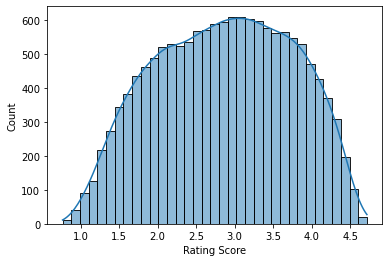

In [3]:
sns.histplot(data=df,x='Rating Score',bins='auto',kde=True)
print(df['Rating Score'].describe())
plt.show()

I'm curious if the anime community is like other fan communities, where great reverence is paid to older
works.  Looking at the scores over time, this is obviously not the case and it seems newer anime generates
a lot more enthusiasm.  This makes me wonder if there are some older, lesser-known works that might be underrated.

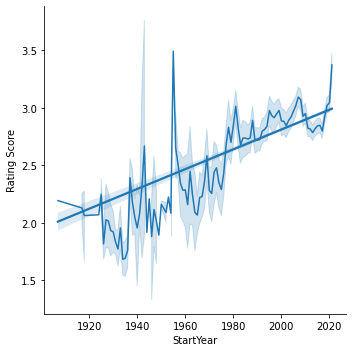

In [4]:
sns.relplot(kind='line',data=df,x='StartYear',y='Rating Score')
sns.regplot(data=df,x='StartYear',y='Rating Score',scatter=False)
plt.show()

Let's see if there might be some anime titles that have gone under the radar.  Wow!  The difference
between popular anime and unpopular anime is so great I need to use a logarithmic scale just to see
it.  It seems there are a great many works that have been largely ignored and have relatively few
reviews, which might make them less accurate.  Let's look into these lesser-reviewed titles and see
if any of them have anything in common with very popular and well-recieved titles.

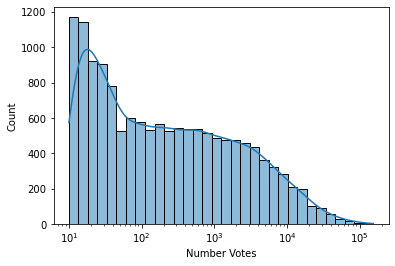

In [5]:
sns.histplot(data=df,x='Number Votes',bins='auto',kde=True,log_scale=(True,False))

First let's get a feel for what people like in anime.  We'll generate a word cloud of the top
5% of best-reviewed works and see what themes stand out.  It would seem that popular anime has 
"World" building and seems to feature a main character who's younger, typically in "High School",
who is on a quest to "find" something.  We also found a few stopwords that weren't included in 
the default list, so we can now strip those out.

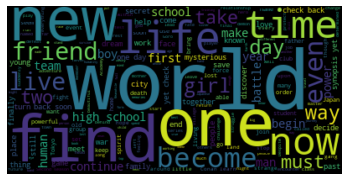

In [6]:
top_scores=np.percentile(df['Rating Score'],95)
df_best=df[df['Rating Score']>=top_scores]

best_words=''
for syn in df_best['Synopsis']:
    best_words+=syn

stopwords = set(STOPWORDS)
stopwords.update(['S','will','story'])
wordcloud = WordCloud(stopwords=stopwords).generate(best_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now that we've got a feel for this dataset, let's start looking for older, underrated 
shows that only have low ratings due to having a small number of votes.  We'll grab 
all the titles that are in the bottom 20% of rating scores, and the bottom 20% of number
of ratings, which were produced before 1990.  I want at least 50 titles here, because I'm
assuming some of these are just legitimately low quality and I'll want to look through
many titles to find a diamond in the rough.

In [7]:
under_reviewed_df=df[df['Number Votes']<np.percentile(df['Number Votes'],20)]
under_reviewed_df=under_reviewed_df[under_reviewed_df['Rating Score']<np.percentile(under_reviewed_df['Rating Score'],20)]
under_reviewed_df=under_reviewed_df[under_reviewed_df['StartYear']<=1990]
under_reviewed_df.describe()

,Anime-PlanetID,Rating Score,Number Votes,StartYear
count,88.000000,88.000000,88.000000,88.000000
mean,12761.215909,1.337409,13.818182,1976.465909
std,2280.707409,0.128521,2.637246,12.669947
min,6527.000000,0.958000,10.000000,1931.000000
25%,11099.250000,1.252750,12.000000,1972.000000
50%,12449.500000,1.356000,14.000000,1978.500000
75%,14989.000000,1.452000,16.000000,1985.250000
max,16100.000000,1.535000,21.000000,1990.000000


In lieu of making a full-blown AI quality prediction algorithm to find animes
that might be good quality, let's shoot from the hip and find works whose 
synopsis lines up well with the synopsis of the most popular works.  We'll
use cosine similarity to quantify how sematically similar each of the works 
are to popular titles, in hopes that we find underrated films that explore
the same themes and storylines as those that are well recieved.

In [8]:
vectorizer = TfidfVectorizer()
best_frequencies=vectorizer.fit_transform([best_words])
underreviewed_frequencies=vectorizer.transform(under_reviewed_df['Synopsis'])
under_reviewed_df['similarity']=cosine_similarity(underreviewed_frequencies,best_frequencies)

Success!  After ranking the under-reviewed titles by their similarity score,
here's five animes that we've identified as "possibly underrated", which might
be worth watching to see if their low scores are not well deserved. Interestingly, most of these are Korean films--that may be the primary 
reason they were snubbed by critics.

In [9]:
under_reviewed_df.sort_values(by='similarity',ascending=False,inplace=True)
print(under_reviewed_df[['Name','Rating Score','Number Votes','similarity']].head())

                    Name  Rating Score  Number Votes  similarity
3808       Golden Batman         1.256            16    0.670653
16395    Yuuyake Banchou         1.474            10    0.565018
2382   Sasurai no Violin         1.398            12    0.505227
661      Robot Taekwon V         1.330            18    0.498549
360        Fengshen Bang         0.958            14    0.479837
